# Multilayer perceptron to classify english spoken words 0 to 9

## Dataset

About 2000 voice recordings are used in the analysis. This dataset is obtained from https://github.com/Jakobovski/free-spoken-digit-dataset

## Mel Frequency Cepstral Coefficient

Python_speech_feature module is used to convert raw audio recordings (.wav audio files) to their corresponding Mel frequency cepstral coefficients (MFCCs). These MFCCs are used to train and test the model. The dataset is split into training(80%) and testing(20%). 

In [1]:
from python_speech_features import mfcc
import scipy.io.wavfile as wav

def get_mfcc(file_path):
    (rate, sig) = wav.read(file_path)
    return mfcc(sig, rate)

In [3]:
def split_train_test(data, test_ratio, seed):
    '''
    divides data into training and testing sets
    '''
    np.random.seed(seed)
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data)*test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data[train_indices], data[test_indices]

In [ ]:
folder_path = r'''/home/sagar/GitHub-Repos/free-spoken-digit-dataset-master/recordings'''

In [11]:

import os
import numpy as np
from numpy import newaxis
labels = []
fileNames = os.listdir(folder_path)
mel_freq = np.empty(shape = (len(fileNames), 60, 12))
for fileName in fileNames:
    #label = int(fileName[0])
    path = os.path.abspath(os.path.join(folder_path, fileName))
    mfcc_temp = get_mfcc(path)                                   
    mfcc_temp.resize(1,60,12)
    np.append(mel_freq, mfcc_temp, axis=0)
    labels.append(int(fileName[0]))

In [6]:
targets = np.array(labels)

In [9]:
train_data, test_data = split_train_test(mel_freq, 0.2, 1)
train_labels, test_labels = split_train_test(targets, 0.2, 1)

In [13]:
# one-hot encoding of labels into 10 categories (0 to 9)
from keras.utils.np_utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

## Model

The model used here is a Sequential model containing four Dense layers. The first three layers uses "relu" activation function and contains 64 hidden layers each. The last layer has an activation function of "softmax" with 10 hidden layers, this layer outputs the probability of the observations for all 10 classes (0 to 9).

"Categorical crossentropy" is used as the loss function to measure the model's performance with accuracy as the metrics and "rmsprop" as the optimizer.

During training, the model is trained on 800 datapoints and is validated on the other 800. Using validation allows to reduces overfitting by tuning hyperparameters.

In [128]:

from keras import models, layers

model = models.Sequential()
model.add(layers.Dense(256, activation='relu', input_shape=(60,12)))
model.add(layers.Dense(256,  activation='relu'))
model.add(layers.Flatten())
model.add(layers.Dense(64,  activation='relu'))
model.add(layers.Dense(10, activation='softmax')) 


model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_151 (Dense)            (None, 60, 256)           3328      
_________________________________________________________________
dense_152 (Dense)            (None, 60, 256)           65792     
_________________________________________________________________
flatten_18 (Flatten)         (None, 15360)             0         
_________________________________________________________________
dense_153 (Dense)            (None, 64)                983104    
_________________________________________________________________
dense_154 (Dense)            (None, 10)                650       
Total params: 1,052,874
Trainable params: 1,052,874
Non-trainable params: 0
_________________________________________________________________


In [28]:
## Validating the approach

x_val = train_data[:800]
partial_x_train = train_data[800:]

y_val = train_labels[:800]
partial_y_train = train_labels[800:]

In [77]:
partial_x_train.shape

(800, 60, 12)

In [129]:
history = model.fit(partial_x_train, partial_y_train, epochs=20, batch_size=50, validation_data=(x_val, y_val))

Train on 800 samples, validate on 800 samples
Epoch 1/20
800/800 [==============================] - 2s 3ms/step - loss: 2.3027 - acc: 0.0962 - val_loss: 2.3028 - val_acc: 0.0900
Epoch 2/20
800/800 [==============================] - 1s 1ms/step - loss: 2.3023 - acc: 0.1188 - val_loss: 2.3030 - val_acc: 0.0900
Epoch 3/20
800/800 [==============================] - 1s 1ms/step - loss: 2.3021 - acc: 0.1187 - val_loss: 2.3032 - val_acc: 0.0900
Epoch 4/20
800/800 [==============================] - 1s 2ms/step - loss: 2.3019 - acc: 0.1188 - val_loss: 2.3034 - val_acc: 0.0900
Epoch 5/20
800/800 [==============================] - 1s 2ms/step - loss: 2.3017 - acc: 0.1188 - val_loss: 2.3036 - val_acc: 0.0900
Epoch 6/20
800/800 [==============================] - 1s 2ms/step - loss: 2.3015 - acc: 0.1187 - val_loss: 2.3037 - val_acc: 0.0900
Epoch 7/20
800/800 [==============================] - 1s 1ms/step - loss: 2.3014 - acc: 0.1187 - val_loss: 2.3039 - val_acc: 0.0900
Epoch 8/20
800/800 [==========

In [98]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

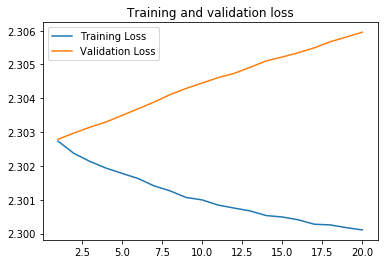

In [100]:
# Plotting training and validation loss

import matplotlib.pyplot as plt

epochs = range(1, len(history_dict['loss'])+1)

loss = history_dict['loss']
val_loss = history_dict['val_loss']

plt.plot(epochs, loss, label="Training Loss")
plt.plot(epochs, val_loss, label="Validation Loss")
plt.title("Training and validation loss")
plt.legend()

plt.show()

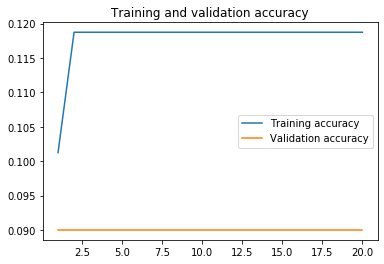

In [101]:
# Plotting training and validation accuracy

plt.clf()

acc = history_dict['acc']
val_acc = history_dict['val_acc']

plt.plot(epochs, acc, label="Training accuracy")
plt.plot(epochs, val_acc, label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()

plt.show()

Plotting validation and training losses and accuracy shows that the model's performance is bad with an accuracy of about 10%. This warrants a review of the model architecture used (Convoluted neural networks may work better than dense), hyperparameter tuning(changing the number of layers, number of hidden layers, epochs and batch size).

# Fitting the model on test data

Predictions contain the probability that the test data (400 datapoints) fall into each of the 10 categories(0 to 9)


In [130]:
predictions = model.predict(test_data)